# Ice Cream Sales

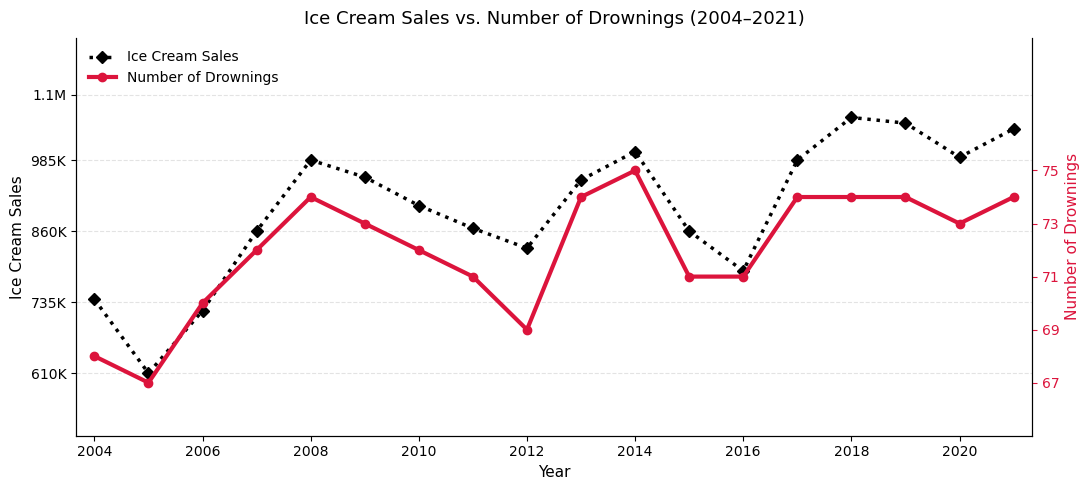

In [37]:
# -------------------------------------------------------------
# Ice Cream Sales (black, left axis) vs. Drownings (red, right)
# -------------------------------------------------------------
import matplotlib.pyplot as plt                                  # plotting
from matplotlib.ticker import FuncFormatter                       # custom tick labels
import numpy as np                                                # convenience (ticks)

# ---- Data (2004–2021) ----
years = np.arange(2004, 2022)                                     # 2004..2021 inclusive

# Black series ≈ Ice Cream Sales (left axis, ~610–1100); read visually from the image
sales = [
    740000, 610000, 720000, 860000, 985000, 955000, 905000, 865000, 830000,
    950000, 1000000, 860000, 790000, 985000, 1060000, 1050000, 990000, 1040000
]

# Red series ≈ Number of Drownings (right axis, ~67–75); read visually from the image
drownings = [
    68, 67, 70, 72, 74, 73, 72, 71, 69,
    74, 75, 71, 71, 74, 74, 74, 73, 74
]

# ---- Figure & Axes ----
plt.figure(figsize=(11, 5))                                       # wide aspect like the reference
ax_left = plt.gca()                                               # left axis (sales)
ax_right = ax_left.twinx()                                        # right axis (drownings)

# ---- Plot: Ice Cream Sales (black, dotted, diamond markers) ----
ax_left.plot(
    years, sales,
    linestyle=":",
    marker="D",
    markersize=6,
    linewidth=2.5,
    color="black",
    label="Ice Cream Sales"
)

# ---- Plot: Number of Drownings (red, solid, circle markers) ----
ax_right.plot(
    years, drownings,
    linestyle="-",
    marker="o",
    markersize=6,
    linewidth=3.0,
    color="crimson",
    label="Number of Drownings"
)

# ---- Axes ranges & ticks (to match the look) ----
ax_left.set_ylim(500000, 1200000)                         
ax_right.set_ylim(65, 80)                                

# X ticks every 2 years, rotated slightly
xticks = np.arange(2004, 2022, 2)
ax_left.set_xticks(xticks)
ax_left.set_xticklabels([str(y) for y in xticks], rotation=0)

# Left y ticks: 610K, 735K, 860K, 985K, 1.1M
ax_left.set_yticks([610000, 735000, 860000, 985000, 1100000])

# Left y formatter: show 'K' and 'M' properly
def left_k_formatter(x, _):
    if x >= 1_000_000:
        return f"{x/1_000_000:.1f}M"
    else:
        return f"{int(x/1000)}K"

ax_left.yaxis.set_major_formatter(FuncFormatter(left_k_formatter))

# Right y ticks and faint labels (67,69,71,73,75)
ax_right.set_yticks([67, 69, 71, 73, 75])

# ---- Labels & Title (English) ----
ax_left.set_xlabel("Year", fontsize=11)
ax_left.set_ylabel("Ice Cream Sales", fontsize=11, color="black")
ax_right.set_ylabel("Number of Drownings", fontsize=11, color="crimson")
plt.title("Ice Cream Sales vs. Number of Drownings (2004–2021)", fontsize=13, pad=10)

# ---- Gridlines (horizontal only, light) ----
ax_left.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.35)
ax_left.grid(axis="x", visible=False)

# ---- Legends (separate so colors match axes) ----
# Place both labels in one legend by combining handles
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
handles = handles_left + handles_right
labels = labels_left + labels_right
leg = ax_left.legend(handles, labels, loc="upper left", frameon=False)

# ---- Cosmetic tweaks to resemble the reference ----
for spine in ["top"]:
    ax_left.spines[spine].set_visible(False)
    ax_right.spines[spine].set_visible(False)

ax_left.tick_params(axis="y", colors="black")
ax_right.tick_params(axis="y", colors="crimson")
ax_left.margins(x=0.02)
plt.tight_layout()
plt.savefig('images/chp4_ice_drown.png', dpi=300)  # Save image
plt.show()

# Causal Inference - Advertising and Sales

In [17]:
# ---------------------------------------------
# Causal simulation: Advertising (T) → Sales (Y) with Holiday (Z) as confounder
# ---------------------------------------------
import numpy as np                                  # numerical ops
import pandas as pd                                 # tabular ops
from dataclasses import dataclass                   # simple parameter bundle
from sklearn.linear_model import LinearRegression   # OLS regression
import matplotlib.pyplot as plt                     # Graphs

In [13]:
# -----------------------------
# 1) Set reproducibility & params
# -----------------------------
np.random.seed(42)                                  # fixed seed for reproducibility

@dataclass
class SimParams:
    n: int = 50_000                                 # number of observations
    p_holiday: float = 0.30                         # P(Z=1): 30% of the data will be holidays
    alpha0: float = -1.25                           # log-odds of advertising when Z=0
    alpha1: float = 2.00                            # increase in log-odds of ads when Z=1 (confounding strength)
    beta0: float = 100.0                            # baseline profit level
    tau: float = 12.0                               # true causal effect of advertising on profit
    gamma: float = 25.0                             # direct holiday lift on profit (confounding path)
    sigma: float = 20.0                             # noise std for outcome

P = SimParams()                                     # instantiate default parameters
P

SimParams(n=50000, p_holiday=0.3, alpha0=-1.25, alpha1=2.0, beta0=100.0, tau=12.0, gamma=25.0, sigma=20.0)

In [3]:
# -----------------------------
# 2) Helper functions
# -----------------------------
def sigmoid(x):                                     # logistic link
    return 1.0 / (1.0 + np.exp(-x))

def gen_data(P: SimParams):
    """Generate (Z, T, Y) under a confounded treatment assignment."""
    Z = np.random.binomial(1, P.p_holiday, size=P.n)                # Holiday indicator (confounder)
    p_T = sigmoid(P.alpha0 + P.alpha1 * Z)                          # P(T=1 | Z) via logistic
    T = np.random.binomial(1, p_T)                                  # Advertising assignment depends on Z
    eps = np.random.normal(0.0, P.sigma, size=P.n)                  # mean-zero noise
    Y = P.beta0 + P.tau * T + P.gamma * Z + eps                     # Outcome with true τ and direct holiday lift
    return pd.DataFrame({"Z": Z, "T": T, "Y": Y, "p_T": p_T})       # return full dataset

In [6]:
# -----------------------------
# 3) Estimators
# -----------------------------
def diff_in_means(df: pd.DataFrame) -> float:
    """Naïve difference in means: E[Y|T=1] - E[Y|T=0] (biased if T ⟂̸ Z)."""
    return df.loc[df["T"] == 1, "Y"].mean() - df.loc[df["T"] == 0, "Y"].mean()

def backdoor_stratified(df: pd.DataFrame) -> float:
    """
    Backdoor adjustment by conditioning on Z:
    τ̂_adj = Σ_z ( E[Y|T=1,Z=z] - E[Y|T=0,Z=z] ) * P(Z=z)
    """
    w0 = (df.Z == 0).mean()                                          # P(Z=0)
    w1 = 1.0 - w0                                                    # P(Z=1)
    m10 = df.loc[(df["T"] == 1) & (df.Z == 0), "Y"].mean()           # E[Y|T=1,Z=0]
    m00 = df.loc[(df["T"] == 0) & (df.Z == 0), "Y"].mean()           # E[Y|T=0,Z=0]
    m11 = df.loc[(df["T"] == 1) & (df.Z == 1), "Y"].mean()           # E[Y|T=1,Z=1]
    m01 = df.loc[(df["T"] == 0) & (df.Z == 1), "Y"].mean()           # E[Y|T=0,Z=1]
    return (m10 - m00) * w0 + (m11 - m01) * w1                       # weighted average of within-stratum effects

def ols_coeff(df: pd.DataFrame, controls: list) -> float:
    """
    OLS coefficient for T from regression: Y = β0 + τ*T + θ'controls + ε
    Returns τ̂_OLS (the coefficient on T).
    """
    X = df[["T"] + controls].values                                  # design matrix with T and controls
    y = df["Y"].values                                               # outcome
    model = LinearRegression(fit_intercept=True).fit(X, y)           # fit OLS
    return float(model.coef_[0])                                     # coefficient corresponding to T

In [15]:
# -----------------------------
# 4) Run simulation
# -----------------------------
df = gen_data(P)                                                     # simulate dataset

# Naïve estimate (ignores Z)
tau_hat_naive = diff_in_means(df)                                    # biased if Z confounds T and Y

# Backdoor (stratified) estimate (adjusts for Z)
tau_hat_adj = backdoor_stratified(df)                                # unbiased under correct stratification

# OLS without controls (should be biased)
tau_hat_ols_nocontrol = ols_coeff(df, controls=[])                   # regression omitting Z

# OLS with Z control (blocks backdoor)
tau_hat_ols_withZ = ols_coeff(df, controls=["Z"])                    # regression controlling for Z

df

,Z,T,Y,p_T
0,0,1,128.854222,0.222700
1,1,1,187.477740,0.679179
2,1,1,134.997370,0.679179
3,0,0,56.047912,0.222700
4,0,0,128.506947,0.222700
...,...,...,...,...
49995,0,1,91.377929,0.222700
49996,0,1,142.191571,0.222700
49997,1,1,119.084143,0.679179
49998,0,0,92.208382,0.222700


In [9]:
# -----------------------------
# 5) Summarize results (optional printing)
# -----------------------------
summary = pd.DataFrame({                                             # collect estimates for comparison
    "Estimator": [
        "True tau",
        "Naive diff-in-means (no Z)",
        "Backdoor (stratify on Z)",
        "OLS (no Z)",
        "OLS (+Z)"
    ],
    "Estimate": [
        P.tau,
        tau_hat_naive,
        tau_hat_adj,
        tau_hat_ols_nocontrol,
        tau_hat_ols_withZ
    ]
})

print(summary.round(3))                                            # <-- Uncomment to view results

                    Estimator  Estimate
0                    True tau    12.000
1  Naive diff-in-means (no Z)    22.391
2    Backdoor (stratify on Z)    11.975
3                  OLS (no Z)    22.391
4                    OLS (+Z)    11.957


    0 By construction, we set the causal effect of advertising in our simulated world.
    1 This estimator just compares average sales with ads vs. without ads, ignoring holidays.
    2 Here we compute the effect within holidays and within non-holidays, then weight by frequency.
    3 Regression Sales ~ Advertising without controlling for holidays (does not account for the confounder).
    4 This controls for the confounder (holiday), blocking the backdoor path.

In [11]:
# -----------------------------
# 6) Stress tests (optional): vary confounding & noise
# -----------------------------
def sweep_alpha1(alpha_grid, P_base=P):
    """Show how naive bias grows with confounding strength (alpha1)."""
    rows = []
    for a1 in alpha_grid:
        P_new = SimParams(**{**P_base.__dict__, "alpha1": a1})       # copy P and modify alpha1
        df_ = gen_data(P_new)                                        # simulate
        rows.append({
            "alpha1": a1,
            "true_tau": P_new.tau,
            "naive": diff_in_means(df_),
            "backdoor": backdoor_stratified(df_),
            "ols_noZ": ols_coeff(df_, controls=[]),
            "ols_Z": ols_coeff(df_, controls=["Z"])
        })
    return pd.DataFrame(rows)

alpha_sweep = sweep_alpha1(alpha_grid=np.linspace(0, 3, 7))        # <-- Uncomment to run sweep
print(alpha_sweep.round(3))                                        # <-- Uncomment to view sweep

# ---------------------------------------------
# Notes:
# - The naïve estimator and OLS w/out Z overstate the ad effect when Z↑T and Z↑Y.
# - Backdoor stratification and OLS(+Z) recover τ in expectation (up to sampling noise).
# - Adjust P.gamma (holiday lift) and P.alpha1 (ad targeting on holidays) to tune confounding.
# - Increase P.n to reduce Monte Carlo noise; increase P.sigma to raise outcome noise.
# ---------------------------------------------

   alpha1  true_tau   naive  backdoor  ols_noZ   ols_Z
0     0.0      12.0  11.838    11.954   11.838  11.955
1     0.5      12.0  15.069    12.202   15.069  12.215
2     1.0      12.0  17.578    12.072   17.578  12.073
3     1.5      12.0  19.884    11.861   19.884  11.823
4     2.0      12.0  22.227    11.751   22.227  11.733
5     2.5      12.0  24.077    11.941   24.077  11.940
6     3.0      12.0  25.644    12.053   25.644  12.049


This block is a stress test that shows how confounding affects our estimators. Systematically vary alpha1 (the parameter that makes advertising more likely during holidays). alpha1 = confounding strength:

    If alpha1 = 0, ads are assigned randomly, independent of holidays.
    If alpha1 > 0, ads are much more likely on holidays → stronger confounding.

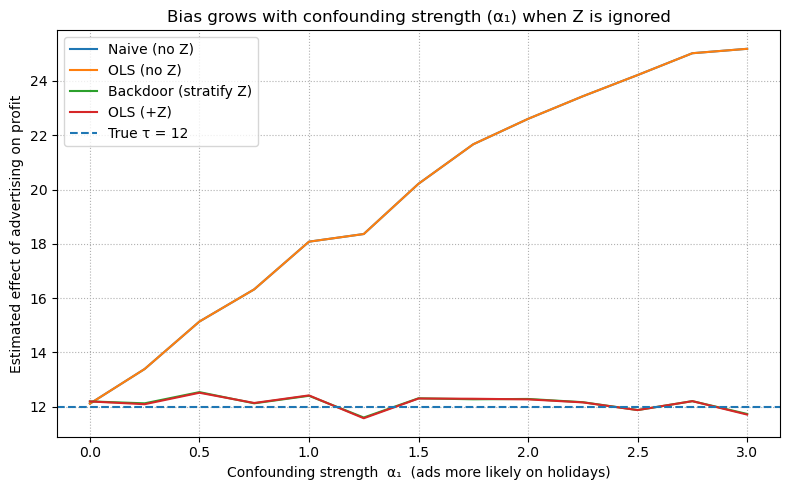

In [18]:
# -----------------------------
# 1) Generate the sweep table
# -----------------------------
alpha_grid = np.linspace(0, 3, 13)                                                       # 13 points from 0 to 3
alpha_sweep = sweep_alpha1(alpha_grid=alpha_grid)                                        # run stress test sweep

# -----------------------------
# 2) Plot: estimate vs alpha1
# -----------------------------
plt.figure(figsize=(8, 5))                                                               # create figure

# Plot each estimator curve                                                               
plt.plot(alpha_sweep["alpha1"], alpha_sweep["naive"],     label="Naive (no Z)")          # naive diff-in-means
plt.plot(alpha_sweep["alpha1"], alpha_sweep["ols_noZ"],   label="OLS (no Z)")            # OLS without confounder
plt.plot(alpha_sweep["alpha1"], alpha_sweep["backdoor"],  label="Backdoor (stratify Z)") # stratified backdoor
plt.plot(alpha_sweep["alpha1"], alpha_sweep["ols_Z"],     label="OLS (+Z)")              # OLS controlling for Z

# Horizontal line at true tau
true_tau = alpha_sweep["true_tau"].iloc[0]                                               # true effect (constant)
plt.axhline(true_tau, linestyle="--", linewidth=1.5, label=f"True τ = {true_tau:.0f}")   # reference line

# Labels, title, legend, grid
plt.title("Bias grows with confounding strength (α₁) when Z is ignored")                 # informative title
plt.xlabel("Confounding strength  α₁  (ads more likely on holidays)")                    # x-label
plt.ylabel("Estimated effect of advertising on profit")                                  # y-label
plt.legend(loc="best", frameon=True)                                                     # legend
plt.grid(True, linestyle=":")                                                            # light grid
plt.tight_layout()                                                                       # fit layout
plt.show()                                                                               # Display it

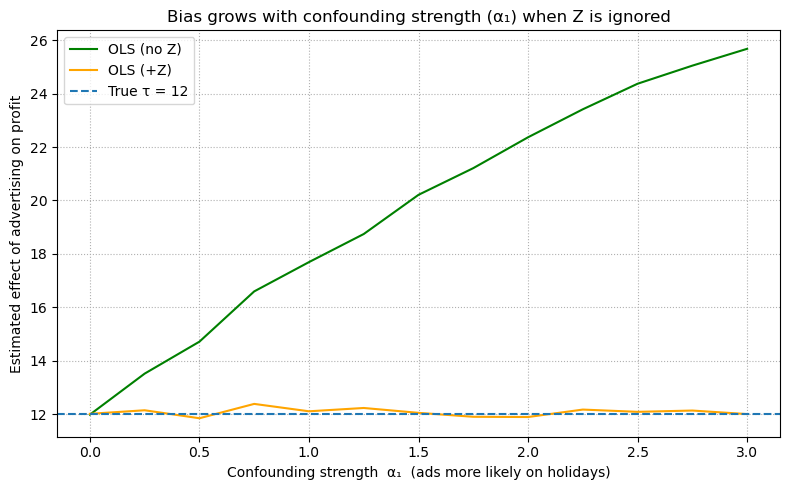

In [25]:
# -----------------------------
# 1) Generate the sweep table
# -----------------------------
alpha_grid = np.linspace(0, 3, 13)                                                       # 13 points from 0 to 3
alpha_sweep = sweep_alpha1(alpha_grid=alpha_grid)                                        # run stress test sweep

# -----------------------------
# 2) Plot: estimate vs alpha1
# -----------------------------
plt.figure(figsize=(8, 5))                                                               # create figure

# Plot each estimator curve                                                               
#plt.plot(alpha_sweep["alpha1"], alpha_sweep["naive"],     label="Naive (no Z)")          # naive diff-in-means
plt.plot(alpha_sweep["alpha1"], alpha_sweep["ols_noZ"],   color="green", label="OLS (no Z)")            # OLS without confounder
#plt.plot(alpha_sweep["alpha1"], alpha_sweep["backdoor"],  label="Backdoor (stratify Z)") # stratified backdoor
plt.plot(alpha_sweep["alpha1"], alpha_sweep["ols_Z"],    color="orange", label="OLS (+Z)")              # OLS controlling for Z

# Horizontal line at true tau
true_tau = alpha_sweep["true_tau"].iloc[0]                                               # true effect (constant)
plt.axhline(true_tau, linestyle="--", linewidth=1.5, label=f"True τ = {true_tau:.0f}")   # reference line

# Labels, title, legend, grid
plt.title("Bias grows with confounding strength (α₁) when Z is ignored")                 # informative title
plt.xlabel("Confounding strength  α₁  (ads more likely on holidays)")                    # x-label
plt.ylabel("Estimated effect of advertising on profit")                                  # y-label
plt.legend(loc="best", frameon=True)                                                     # legend
plt.grid(True, linestyle=":")                                                            # light grid
plt.tight_layout()                                                                       # fit layout
plt.savefig('images/chp4_bias_confounding.png', dpi=300)                                 # Save image
plt.show()                                                                               # Display it